My goal for this notebook is to develop some intuition about poker, specifically for the Texas Hold'em game. 

Some things I want to know is:
1. If I'm dealt certain whole cards, should I play it or not?
2. For certain whole cards, what are my chances of improving my hands?
3. Does the game change when I play with different number of opponents?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from time import time
import itertools
import pickle
import os.path

from Basics import Deck, test_shuffle
from win_lose import evaluate_7cards, evaluate_5cards, best_hand
from Game_Board import Test_Game

Testing basic functions and methods

In [2]:
mydeck = Deck()

In [3]:
#showing the unshuffled order of the deck
mydeck.order()

['14♣',
 '2♣',
 '3♣',
 '4♣',
 '5♣',
 '6♣',
 '7♣',
 '8♣',
 '9♣',
 '10♣',
 '11♣',
 '12♣',
 '13♣',
 '14♢',
 '2♢',
 '3♢',
 '4♢',
 '5♢',
 '6♢',
 '7♢',
 '8♢',
 '9♢',
 '10♢',
 '11♢',
 '12♢',
 '13♢',
 '14♡',
 '2♡',
 '3♡',
 '4♡',
 '5♡',
 '6♡',
 '7♡',
 '8♡',
 '9♡',
 '10♡',
 '11♡',
 '12♡',
 '13♡',
 '14♠',
 '2♠',
 '3♠',
 '4♠',
 '5♠',
 '6♠',
 '7♠',
 '8♠',
 '9♠',
 '10♠',
 '11♠',
 '12♠',
 '13♠']

In [4]:
#testing the shuffle function in Deck to see if hands are distributed equally
df_test_shuffle = test_shuffle(mydeck, 10000)

In [5]:
s_test_summary = df_test_shuffle.mean().sort_values(ascending = False).rename('avg_hand_freq')
s_test_summary

11♢    25.9536
10♢    25.8183
6♡     25.7483
7♣     25.6905
3♢     25.6675
14♢    25.6610
5♠     25.6607
3♣     25.6222
9♠     25.5911
13♢    25.5835
7♠     25.5828
8♣     25.5709
6♢     25.5600
3♡     25.5592
5♢     25.5543
2♣     25.5497
3♠     25.5464
2♢     25.5426
7♡     25.5228
4♡     25.5168
11♡    25.5134
5♣     25.5127
10♠    25.4965
10♡    25.4944
5♡     25.4929
13♣    25.4907
11♣    25.4853
14♣    25.4721
8♡     25.4694
9♣     25.4669
4♣     25.4606
2♡     25.4395
4♠     25.4377
12♡    25.4300
4♢     25.4295
14♠    25.4256
8♢     25.4134
6♣     25.4129
9♡     25.4114
8♠     25.4053
6♠     25.4035
9♢     25.4003
13♠    25.4000
7♢     25.3970
2♠     25.3730
11♠    25.3713
13♡    25.3656
12♢    25.3557
12♣    25.3478
14♡    25.3300
10♣    25.3269
12♠    25.2665
Name: avg_hand_freq, dtype: float64

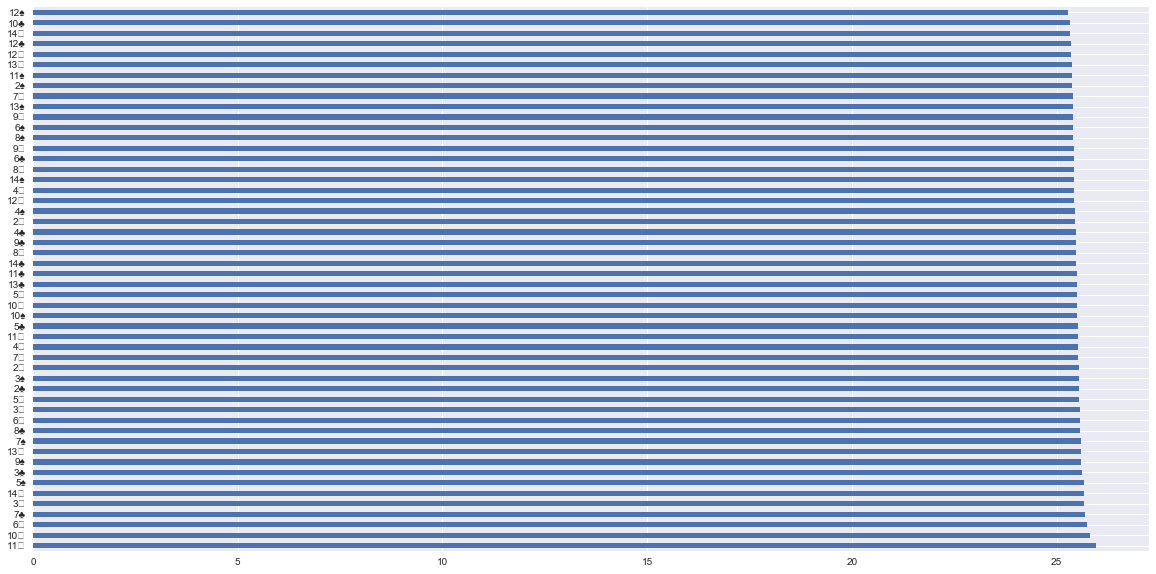

In [6]:
plt.rcParams['figure.figsize'] = [20, 10]
s_test_summary.plot(kind = 'barh')
plt.show()

Seems like the classes and the shuffle functions working okay

Trying to run some code a few times to collect some simulation data

In [7]:
print('starting time: {}'.format(time()))
t0 = time()
winning_df = pd.DataFrame()
hands = 200000 #200000, 46107 seconds = 768 min = 12 hrs
participants = 2
for i in range(hands):

    game_info = []
    whole_cards, comm = Test_Game('HOLDEM', participants)
    
    for player in whole_cards:
        player_cards = whole_cards[player]
        game_info.append([player, player_cards, comm])

    game_info_df = pd.DataFrame(game_info, columns = ['player', 'whole', 'comm'])
    game_info_df['combined'] = game_info_df['whole'] + game_info_df['comm']
    game_info_df['mess'] = game_info_df['combined'].apply(evaluate_7cards)
    game_info_df['best hand'] = game_info_df['mess'].apply(lambda x:x[0][0])
    game_info_df['eval'] = game_info_df['mess'].apply(lambda x:x[0][1])
    best = best_hand(list(game_info_df['mess'].apply(lambda x:x[0])))

    game_info_df['winner'] = game_info_df['eval'].apply(lambda x: 1 if best[0][1] == x else 0)
    game_info_df['round'] = i
    
    winning_df = winning_df.append(game_info_df)
    
print('took {} seconds'.format(time() - t0))
#seems like for every 10 games, it takes ~5 seconds to run the algo
#so 1,000,000 games should take 500,000 seconds = 8333 mins = 138 hrs = 5.7 days to run.

starting time: 1533760722.2833095
took 14112.756658554077 seconds


In [8]:
winning_df.head(20)

,player,whole,comm,combined,mess,best hand,eval,winner,round
0,0,"[6♠, 4♡]","[3♢, 10♢, 9♡, 10♡, 9♣]","[6♠, 4♡, 3♢, 10♢, 9♡, 10♡, 9♣]","[((6♠, 10♢, 9♡, 10♡, 9♣), (3, 2 Pairs, [10, 9]...","(6♠, 10♢, 9♡, 10♡, 9♣)","(3, 2 Pairs, [10, 9], 6)",0,0
1,1,"[5♢, 7♣]","[3♢, 10♢, 9♡, 10♡, 9♣]","[5♢, 7♣, 3♢, 10♢, 9♡, 10♡, 9♣]","[((7♣, 10♢, 9♡, 10♡, 9♣), (3, 2 Pairs, [10, 9]...","(7♣, 10♢, 9♡, 10♡, 9♣)","(3, 2 Pairs, [10, 9], 7)",1,0
0,0,"[4♢, 3♠]","[9♠, 3♣, 11♣, 7♡, 6♣]","[4♢, 3♠, 9♠, 3♣, 11♣, 7♡, 6♣]","[((3♠, 9♠, 3♣, 11♣, 7♡), (2, 1 Pair, 3, [11, 9...","(3♠, 9♠, 3♣, 11♣, 7♡)","(2, 1 Pair, 3, [11, 9, 7])",0,1
1,1,"[6♡, 4♡]","[9♠, 3♣, 11♣, 7♡, 6♣]","[6♡, 4♡, 9♠, 3♣, 11♣, 7♡, 6♣]","[((6♡, 9♠, 11♣, 7♡, 6♣), (2, 1 Pair, 6, [11, 9...","(6♡, 9♠, 11♣, 7♡, 6♣)","(2, 1 Pair, 6, [11, 9, 7])",1,1
0,0,"[9♠, 14♢]","[3♣, 12♣, 8♠, 8♢, 13♣]","[9♠, 14♢, 3♣, 12♣, 8♠, 8♢, 13♣]","[((14♢, 12♣, 8♠, 8♢, 13♣), (2, 1 Pair, 8, [14,...","(14♢, 12♣, 8♠, 8♢, 13♣)","(2, 1 Pair, 8, [14, 13, 12])",1,2
1,1,"[11♣, 4♠]","[3♣, 12♣, 8♠, 8♢, 13♣]","[11♣, 4♠, 3♣, 12♣, 8♠, 8♢, 13♣]","[((11♣, 12♣, 8♠, 8♢, 13♣), (2, 1 Pair, 8, [13,...","(11♣, 12♣, 8♠, 8♢, 13♣)","(2, 1 Pair, 8, [13, 12, 11])",0,2
0,0,"[2♡, 13♡]","[7♡, 9♢, 13♠, 8♠, 5♡]","[2♡, 13♡, 7♡, 9♢, 13♠, 8♠, 5♡]","[((13♡, 7♡, 9♢, 13♠, 8♠), (2, 1 Pair, 13, [9, ...","(13♡, 7♡, 9♢, 13♠, 8♠)","(2, 1 Pair, 13, [9, 8, 7])",1,3
1,1,"[14♠, 4♡]","[7♡, 9♢, 13♠, 8♠, 5♡]","[14♠, 4♡, 7♡, 9♢, 13♠, 8♠, 5♡]","[((14♠, 7♡, 9♢, 13♠, 8♠), (1, High, [14, 13, 9...","(14♠, 7♡, 9♢, 13♠, 8♠)","(1, High, [14, 13, 9, 8, 7], 0)",0,3
0,0,"[13♣, 12♣]","[5♡, 11♠, 9♢, 8♠, 8♣]","[13♣, 12♣, 5♡, 11♠, 9♢, 8♠, 8♣]","[((13♣, 12♣, 11♠, 8♠, 8♣), (2, 1 Pair, 8, [13,...","(13♣, 12♣, 11♠, 8♠, 8♣)","(2, 1 Pair, 8, [13, 12, 11])",1,4
1,1,"[3♡, 2♡]","[5♡, 11♠, 9♢, 8♠, 8♣]","[3♡, 2♡, 5♡, 11♠, 9♢, 8♠, 8♣]","[((5♡, 11♠, 9♢, 8♠, 8♣), (2, 1 Pair, 8, [11, 9...","(5♡, 11♠, 9♢, 8♠, 8♣)","(2, 1 Pair, 8, [11, 9, 5])",0,4


In [7]:
#might want to save this thing
#should run it for 2, 5 and 10 players
#winner_10p_filename = 'Data/winner_sim_200k_10p.pickle' #this is for 10p
#winner_5p_filename = 'Data/winner_sim_200k_5p.pickle' #this is for 5p
winner_2p_filename = 'Data/winner_sim_200k_2p.pickle' #this is for 2p

In [10]:
#not sure why this didn't work with the if statement
with open(winner_2p_filename, 'wb') as handle: 
    pickle.dump(winning_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
with open(winner_2p_filename, 'rb') as handle:
    winning_df = pickle.load(handle)

In [9]:
#these two functions help me come up with some classifications
def suit_cat(x):
    if x[0] == x[1]:
        return 'same'
    else:
        return 'diff'
    
def rank_cat(x):
    max_rank = max(int(x[0]), int(x[1]))
    min_rank = min(int(x[0]), int(x[1]))
    
    if max_rank == min_rank:
        status1 = 'pair'
    elif abs(max_rank - min_rank) == 1 or (max_rank == 14 and min_rank == 2):
        status1 = '1gap'
    elif abs(max_rank - min_rank) == 2 or (max_rank == 14 and min_rank == 3):
        status1 = '2gap'
    elif abs(max_rank - min_rank) == 3 or (max_rank == 14 and min_rank == 4):
        status1 = '3gap'
    elif abs(max_rank - min_rank) == 4 or (max_rank == 14 and min_rank == 5):
        status1 = '4gap'
    else:
        status1 = '5gap+' 
        
    if max_rank >= 11:
        status2 = 'high'
    elif max_rank >= 6:
        status2 = 'mid'
    else:
        status2 = 'low'
    return status2 + ' ' + status1

In [10]:
winning_df['suit cat'] = winning_df['whole'].apply(lambda x: [i[-1] for i in x]).apply(suit_cat)
winning_df['rank'] = winning_df['whole'].apply(lambda x: [int(i[:-1]) for i in x]).apply(sorted).apply(tuple)
winning_df['rank cat'] = winning_df['rank'].apply(rank_cat)
print(winning_df.shape) #won't be (234139, 6)
winning_df.head()

#do we need more hands? the 10 player game have 2M hands (5x)

(400000, 12)


,player,whole,comm,combined,mess,best hand,eval,winner,round,suit cat,rank,rank cat
0,0,"[6♠, 4♡]","[3♢, 10♢, 9♡, 10♡, 9♣]","[6♠, 4♡, 3♢, 10♢, 9♡, 10♡, 9♣]","[((6♠, 10♢, 9♡, 10♡, 9♣), (3, 2 Pairs, [10, 9]...","(6♠, 10♢, 9♡, 10♡, 9♣)","(3, 2 Pairs, [10, 9], 6)",0,0,diff,"(4, 6)",mid 2gap
1,1,"[5♢, 7♣]","[3♢, 10♢, 9♡, 10♡, 9♣]","[5♢, 7♣, 3♢, 10♢, 9♡, 10♡, 9♣]","[((7♣, 10♢, 9♡, 10♡, 9♣), (3, 2 Pairs, [10, 9]...","(7♣, 10♢, 9♡, 10♡, 9♣)","(3, 2 Pairs, [10, 9], 7)",1,0,diff,"(5, 7)",mid 2gap
0,0,"[4♢, 3♠]","[9♠, 3♣, 11♣, 7♡, 6♣]","[4♢, 3♠, 9♠, 3♣, 11♣, 7♡, 6♣]","[((3♠, 9♠, 3♣, 11♣, 7♡), (2, 1 Pair, 3, [11, 9...","(3♠, 9♠, 3♣, 11♣, 7♡)","(2, 1 Pair, 3, [11, 9, 7])",0,1,diff,"(3, 4)",low 1gap
1,1,"[6♡, 4♡]","[9♠, 3♣, 11♣, 7♡, 6♣]","[6♡, 4♡, 9♠, 3♣, 11♣, 7♡, 6♣]","[((6♡, 9♠, 11♣, 7♡, 6♣), (2, 1 Pair, 6, [11, 9...","(6♡, 9♠, 11♣, 7♡, 6♣)","(2, 1 Pair, 6, [11, 9, 7])",1,1,same,"(4, 6)",mid 2gap
0,0,"[9♠, 14♢]","[3♣, 12♣, 8♠, 8♢, 13♣]","[9♠, 14♢, 3♣, 12♣, 8♠, 8♢, 13♣]","[((14♢, 12♣, 8♠, 8♢, 13♣), (2, 1 Pair, 8, [14,...","(14♢, 12♣, 8♠, 8♢, 13♣)","(2, 1 Pair, 8, [14, 13, 12])",1,2,diff,"(9, 14)",high 5gap+


This is to setup a basic dataframe where we can left join to

In [11]:
all_possible_whole = pd.DataFrame({'whole':[whole for whole in list(itertools.combinations(mydeck.order(), 2))]})
print(all_possible_whole.iloc[100:106])
all_possible_whole['whole rank'] = all_possible_whole['whole'].apply(lambda x: [int(i[:-1]) for i in x]).apply(lambda x: sorted(x)).apply(tuple)
all_possible_whole['whole suit'] = all_possible_whole['whole'].apply(lambda x: [i[-1] for i in x]).apply(lambda x: sorted(x)).apply(tuple)
all_possible_whole['whole'] = all_possible_whole['whole'].apply(sorted).apply(tuple)
print(all_possible_whole.iloc[100:106])
print(all_possible_whole.shape)

         whole
100   (4♡, 9♠)
101  (6♠, 14♢)
102   (6♠, 5♠)
103  (6♠, 11♣)
104  (6♠, 13♣)
105   (6♠, 7♡)
         whole whole rank whole suit
100   (4♡, 9♠)     (4, 9)     (♠, ♡)
101  (14♢, 6♠)    (6, 14)     (♠, ♢)
102   (5♠, 6♠)     (5, 6)     (♠, ♠)
103  (11♣, 6♠)    (6, 11)     (♠, ♣)
104  (13♣, 6♠)    (6, 13)     (♠, ♣)
105   (6♠, 7♡)     (6, 7)     (♠, ♡)
(1326, 3)


In [12]:
winning_df_summary = winning_df[winning_df['winner'] == 1]['whole'].apply(sorted).apply(tuple).copy().value_counts().to_frame()
winning_df_summary.rename(columns = {'whole': 'winning counts'}, inplace = True)
print(winning_df_summary.head())
print(winning_df_summary.shape)

            winning counts
(14♡, 14♢)             276
(11♠, 11♡)             259
(14♢, 14♣)             253
(13♠, 13♢)             252
(12♠, 12♢)             252
(1326, 1)


In [13]:
whole_df = winning_df['whole'].apply(sorted).apply(tuple).copy().value_counts().to_frame()
whole_df.rename(columns = {'whole': 'whole counts'}, inplace = True)
print(whole_df.head())
print(whole_df.shape)

           whole counts
(10♣, 8♠)           365
(11♡, 3♢)           349
(3♠, 4♠)            348
(11♢, 4♠)           347
(13♣, 7♢)           347
(1326, 1)


Check if your algo is working...

In [14]:
winning_df_summary['winning counts'].sum() #there are way more tied hands in a 10 person game.

208850

In [16]:
all_possible_whole[all_possible_whole['whole rank'] == (2, 2)]

,whole,whole rank,whole suit
435,"(2♠, 2♢)","(2, 2)","(♠, ♢)"
454,"(2♠, 2♣)","(2, 2)","(♠, ♣)"
457,"(2♠, 2♡)","(2, 2)","(♠, ♡)"
909,"(2♢, 2♣)","(2, 2)","(♢, ♣)"
912,"(2♡, 2♢)","(2, 2)","(♡, ♢)"
1273,"(2♡, 2♣)","(2, 2)","(♡, ♣)"


In [17]:
all_possible_whole[all_possible_whole['whole rank'] == (2, 14)]
#seems like my code is working

,whole,whole rank,whole suit
155,"(14♢, 2♠)","(2, 14)","(♠, ♢)"
168,"(14♢, 2♢)","(2, 14)","(♢, ♢)"
187,"(14♢, 2♣)","(2, 14)","(♢, ♣)"
190,"(14♢, 2♡)","(2, 14)","(♡, ♢)"
425,"(14♡, 2♠)","(2, 14)","(♠, ♡)"
450,"(14♣, 2♠)","(2, 14)","(♠, ♣)"
456,"(14♠, 2♠)","(2, 14)","(♠, ♠)"
555,"(14♡, 2♢)","(2, 14)","(♡, ♢)"
574,"(14♡, 2♣)","(2, 14)","(♡, ♣)"
577,"(14♡, 2♡)","(2, 14)","(♡, ♡)"


Develop some analysis for the DataFrame and answer the following questions:
1. what hands have very slim chance of winning? by rank and suits?
    - suits can be classified as matching or not
    - ranks can be classified as connecting, 1 gap, 2 gaps, etc
    - ranks can also be looked at by pairs, have at least an Ace, King, etc
2. what is the cutoff standard for winning percentages?
    - we can sort and plot. see if there's an elbow in the plot, for the categories that we've came up with
    - we can also answer some myths:
        - are 2, 7s the worst hands?
        - small pairs, do they always suck?
3. What ends up being the eventual winners?

some classification ideas:
1. suit:
    - same suit
    - different suit
  
2. rank:
    - pair of different sizes
    - at least a high card
    - does suit play a dramatic role?
    - gaps (0, 1, 2, 3, 4, 5+)
    
Also, how do things differ for 10 player, 5 player, and 2 player games? Is what we've found about 10 players not applicable anymore?

In [18]:
all_possible_whole['suit cat'] = all_possible_whole['whole suit'].apply(suit_cat)
all_possible_whole['rank cat'] = all_possible_whole['whole rank'].apply(rank_cat)
all_possible_whole[all_possible_whole['whole rank'] == (3, 14)]

,whole,whole rank,whole suit,suit cat,rank cat
157,"(14♢, 3♣)","(3, 14)","(♢, ♣)",diff,high 2gap
167,"(14♢, 3♢)","(3, 14)","(♢, ♢)",same,high 2gap
173,"(14♢, 3♡)","(3, 14)","(♡, ♢)",diff,high 2gap
194,"(14♢, 3♠)","(3, 14)","(♠, ♢)",diff,high 2gap
506,"(14♡, 3♣)","(3, 14)","(♡, ♣)",diff,high 2gap
531,"(14♣, 3♣)","(3, 14)","(♣, ♣)",same,high 2gap
537,"(14♠, 3♣)","(3, 14)","(♠, ♣)",diff,high 2gap
554,"(14♡, 3♢)","(3, 14)","(♡, ♢)",diff,high 2gap
560,"(14♡, 3♡)","(3, 14)","(♡, ♡)",same,high 2gap
581,"(14♡, 3♠)","(3, 14)","(♠, ♡)",diff,high 2gap


In [19]:
all_possible_whole = all_possible_whole.merge(whole_df, how = 'outer', left_on = 'whole', right_index = True)
all_possible_whole = all_possible_whole.merge(winning_df_summary, how = 'outer', left_on = 'whole', right_index = True)
#all_possible_whole['whole occurance'] = all_possible_whole['whole counts'] / hands / participants
#all_possible_whole['whole winning %'] = all_possible_whole['winning counts'] / all_possible_whole['whole counts']
print(all_possible_whole.shape)
print(all_possible_whole.head())

(1326, 7)
        whole whole rank whole suit suit cat    rank cat  whole counts  \
0   (11♠, 4♡)    (4, 11)     (♠, ♡)     diff  high 5gap+           307   
1   (11♠, 6♠)    (6, 11)     (♠, ♠)     same  high 5gap+           283   
2  (11♠, 14♢)   (11, 14)     (♠, ♢)     diff   high 3gap           299   
3   (11♠, 5♠)    (5, 11)     (♠, ♠)     same  high 5gap+           277   
4  (11♠, 11♣)   (11, 11)     (♠, ♣)     diff   high pair           319   

   winning counts  
0             160  
1             148  
2             186  
3             139  
4             249  


In [20]:
#Average winning percentages = 52.21% (I guess this include the chops)
all_possible_whole['winning counts'].sum() / all_possible_whole['whole counts'].sum()

0.522125

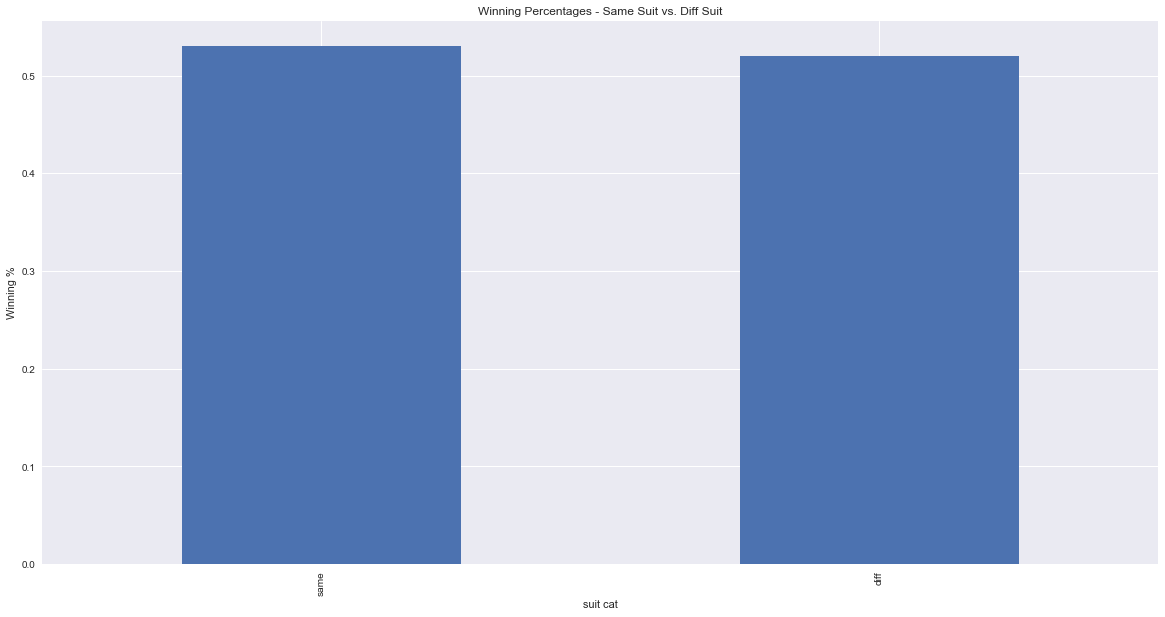

,whole counts,winning counts,whole occurance,whole winning %
suit cat,,,,
same,94109,49851,0.235272,0.529716
diff,305891,158999,0.764728,0.519790


In [25]:
#groupby and compare suit categories to see if there's a clear difference in winning percentage. Plot if necessary
temp = all_possible_whole.groupby('suit cat')[['suit cat', 'whole counts', 'winning counts']].sum()
temp['whole occurance'] = temp['whole counts'] / hands / participants
temp['whole winning %'] = temp['winning counts'] / temp['whole counts']
temp.sort_index(ascending = False, inplace = True)

plt.rcParams['figure.figsize'] = [20, 10]
temp['whole winning %'].plot(kind = 'bar')
plt.ylabel('Winning %')
plt.title('Winning Percentages - Same Suit vs. Diff Suit')
plt.show()
temp.head()

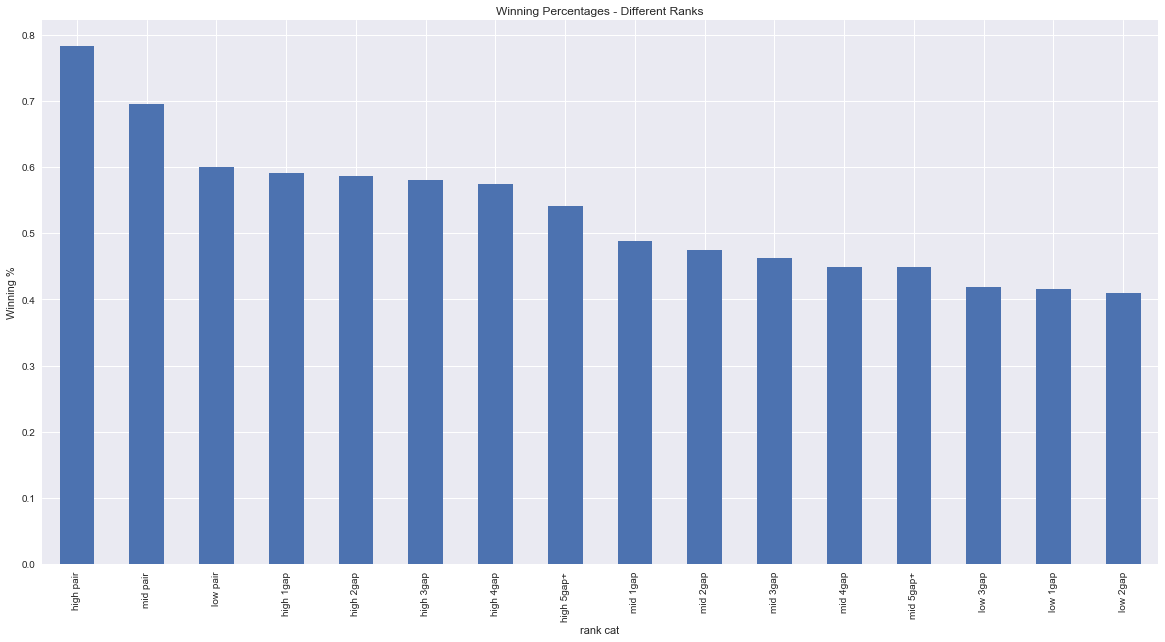

,whole counts,winning counts,whole occurance,whole winning %
rank cat,,,,
high pair,7347,5748,0.018367,0.782360
mid pair,9092,6318,0.022730,0.694897
low pair,7399,4445,0.018498,0.600757
high 1gap,24213,14320,0.060533,0.591418
high 2gap,24054,14110,0.060135,0.586597
high 3gap,23837,13841,0.059592,0.580652
high 4gap,23826,13674,0.059565,0.573911
high 5gap+,106245,57430,0.265612,0.540543
mid 1gap,24070,11760,0.060175,0.488575


In [26]:
#groupby and compare rank categories to see if there's a clear difference in winning percentage. Plot if necessary
temp = all_possible_whole.groupby('rank cat')[['rank cat', 'whole counts', 'winning counts']].sum()
temp['whole occurance'] = temp['whole counts'] / hands / participants
temp['whole winning %'] = temp['winning counts'] / temp['whole counts']
temp.sort_values(by = 'whole winning %', ascending = False, inplace = True)
temp['whole winning %'].plot(kind = 'bar')
plt.ylabel('Winning %')
plt.title('Winning Percentages - Different Ranks')
plt.show()
temp.head(20)

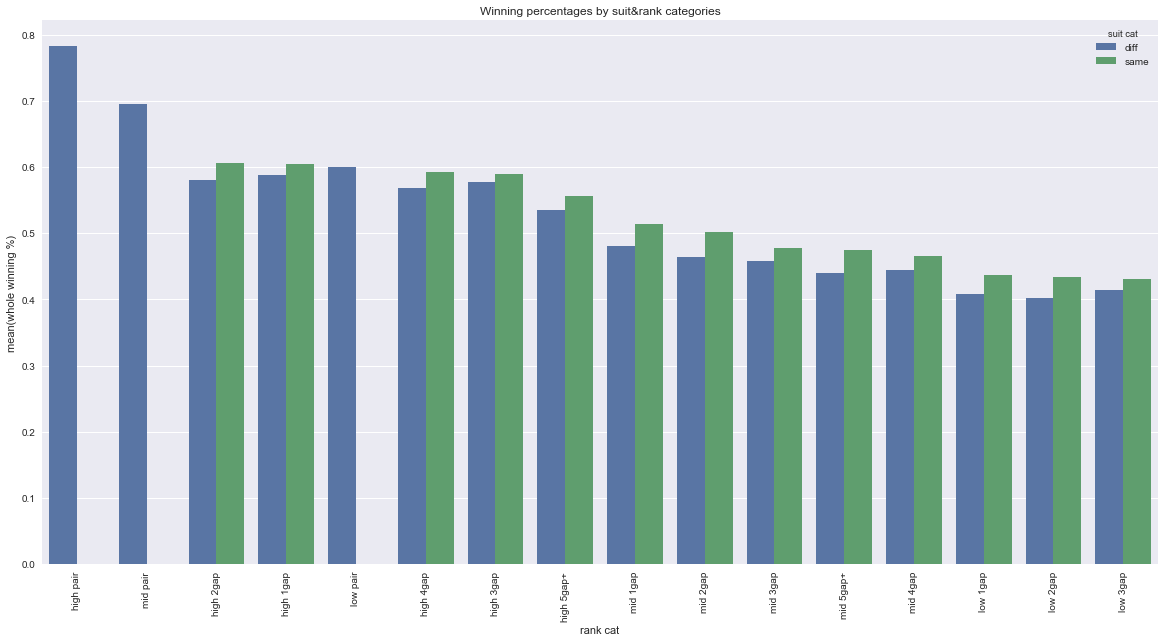

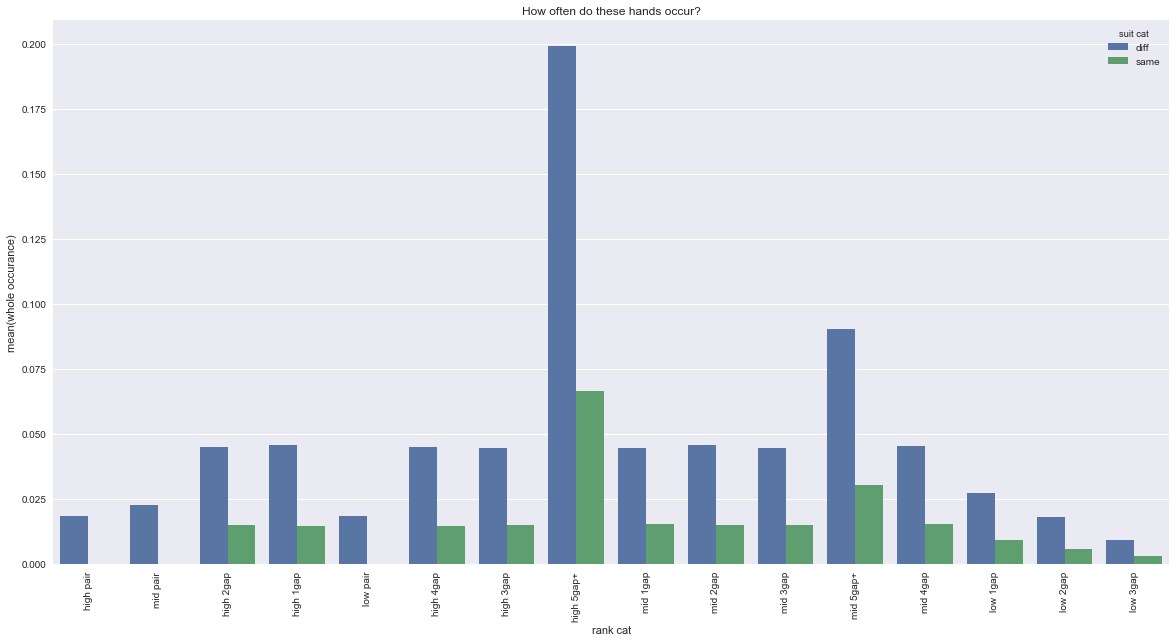

,rank cat,suit cat,whole counts,winning counts,whole occurance,whole winning %
10,high pair,diff,7347,5748,0.018367,0.782360
28,mid pair,diff,9092,6318,0.022730,0.694897
3,high 2gap,same,6062,3672,0.015155,0.605741
1,high 1gap,same,5824,3521,0.014560,0.604567
17,low pair,diff,7399,4445,0.018498,0.600757
7,high 4gap,same,5794,3433,0.014485,0.592509
5,high 3gap,same,5961,3513,0.014903,0.589331
0,high 1gap,diff,18389,10799,0.045972,0.587253
2,high 2gap,diff,17992,10438,0.044980,0.580147
4,high 3gap,diff,17876,10328,0.044690,0.577758


In [27]:
#let's use seaborn to give us a more definitive answer about ranks and suits
temp = all_possible_whole.groupby(['rank cat', 'suit cat'])[['rank cat', 'suit cat', 'whole counts', 'winning counts']].sum().reset_index()
temp['whole occurance'] = temp['whole counts'] / hands / participants
temp['whole winning %'] = temp['winning counts'] / temp['whole counts']
temp.sort_values(by = 'whole winning %', ascending = False, inplace = True)
sns.barplot(data = temp, x = 'rank cat', y = 'whole winning %', hue = 'suit cat')
plt.xticks(rotation = 90)
plt.title('Winning percentages by suit&rank categories')
plt.show()
sns.barplot(data = temp, x = 'rank cat', y = 'whole occurance', hue = 'suit cat')
plt.xticks(rotation = 90)
plt.title('How often do these hands occur?')
plt.show()

temp.head(20)

Within the top winning rank & suit combination, let's actually look at the cards winning percentages and occurances:
1. high pair (~23% chances of winning)
2. mid pair
3. high 1gap same suit
4. high 2gap same suit
5. high 3gap same suit
6. mid 1gap same suit
7. high 4gap same suit
8. mid 2gap same suit
9. low pair (~14.7%)
10. high 5gap+ same suit (~13.7%)

In [28]:
good_whole_criteria = ((all_possible_whole['rank cat'] == 'high pair') | (all_possible_whole['rank cat'] == 'mid pair') | 
                       (all_possible_whole['rank cat'] == 'low pair') | ((all_possible_whole['suit cat'] == 'same') & 
                                                                         ((all_possible_whole['rank cat'] == 'high 1gap') |
                                                                          (all_possible_whole['rank cat'] == 'high 2gap') |
                                                                          (all_possible_whole['rank cat'] == 'high 3gap') |
                                                                          (all_possible_whole['rank cat'] == 'high 4gap') |
                                                                          (all_possible_whole['rank cat'] == 'high 5gap+') |
                                                                          (all_possible_whole['rank cat'] == 'mid 1gap') |
                                                                          (all_possible_whole['rank cat'] == 'mid 2gap'))))
all_possible_whole[good_whole_criteria].head()

,whole,whole rank,whole suit,suit cat,rank cat,whole counts,winning counts
2,"(5♠, 6♠)","(5, 6)","(♠, ♠)",same,mid 1gap,299,148
7,"(5♠, 5♡)","(5, 5)","(♠, ♡)",diff,low pair,298,186
9,"(12♠, 5♠)","(5, 12)","(♠, ♠)",same,high 5gap+,289,168
10,"(14♠, 5♠)","(5, 14)","(♠, ♠)",same,high 4gap,312,192
11,"(5♠, 5♣)","(5, 5)","(♠, ♣)",diff,low pair,318,201


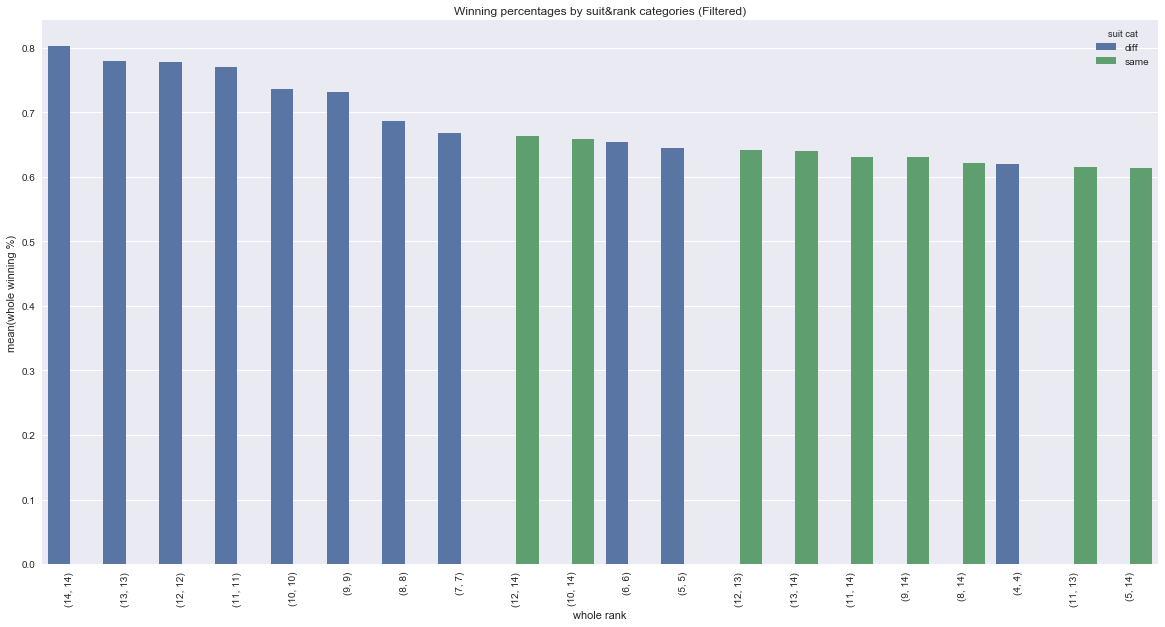

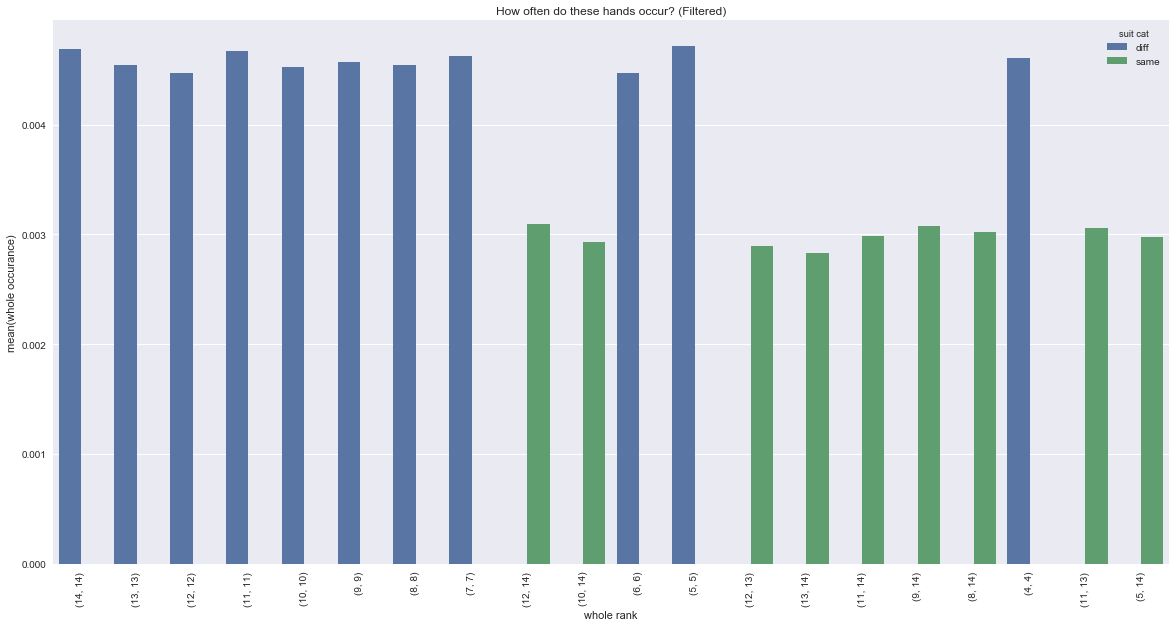

,suit cat,whole rank,whole counts,winning counts,whole occurance,whole winning %
12,diff,"(14, 14)",1876,1505,0.004690,0.802239
11,diff,"(13, 13)",1817,1415,0.004542,0.778756
10,diff,"(12, 12)",1787,1389,0.004468,0.777280
9,diff,"(11, 11)",1867,1439,0.004667,0.770755
8,diff,"(10, 10)",1808,1330,0.004520,0.735619
7,diff,"(9, 9)",1829,1337,0.004573,0.731001
6,diff,"(8, 8)",1818,1248,0.004545,0.686469
5,diff,"(7, 7)",1850,1235,0.004625,0.667568
63,same,"(12, 14)",1238,822,0.003095,0.663974
58,same,"(10, 14)",1174,774,0.002935,0.659284


In [29]:
temp = all_possible_whole[good_whole_criteria].groupby(['suit cat', 'whole rank'])[['whole rank', 'suit cat', 'whole counts', 'winning counts']].sum().reset_index()
temp['whole occurance'] = temp['whole counts'] / hands / participants
temp['whole winning %'] = temp['winning counts'] / temp['whole counts']

temp.sort_values(by = 'whole winning %', ascending = False, inplace = True)

plt.rcParams['figure.figsize'] = [20, 10]
sns.barplot(data = temp.head(20), x = 'whole rank', y = 'whole winning %', hue = 'suit cat')
plt.xticks(rotation = 90)
plt.title('Winning percentages by suit&rank categories (Filtered)')
plt.show()

plt.rcParams['figure.figsize'] = [20, 10]
sns.barplot(data = temp.head(20), x = 'whole rank', y = 'whole occurance', hue = 'suit cat')
plt.xticks(rotation = 90)
plt.title('How often do these hands occur? (Filtered)')
plt.show()

temp.head(20)

Seems like the must-play-hands are:
    1. 20% and up: As, Ks, Qs, Js(these double the average winning percentages)
    2. 18-20%:  10s, (A, Q same), 9s, (J, Q same), (10, K same), (10, Q same)
    3. 17.5-18%: (10, J same),  (K, Q same), (K, J same)
    4. 17-17.5%: 8s, (9, 10 same), (A, K same)
    5. 17% and below: (A, J same), (10, A same) 7s, (9, J same)
    
Let's also look at some of the most occuring hands and their winning percentages

In [30]:
temp.sort_values(by = 'whole occurance', ascending = False, inplace = True)
temp.head(20)

,suit cat,whole rank,whole counts,winning counts,whole occurance,whole winning %
3,diff,"(5, 5)",1885,1215,0.004712,0.644562
12,diff,"(14, 14)",1876,1505,0.004690,0.802239
9,diff,"(11, 11)",1867,1439,0.004667,0.770755
1,diff,"(3, 3)",1863,1087,0.004658,0.583468
5,diff,"(7, 7)",1850,1235,0.004625,0.667568
2,diff,"(4, 4)",1841,1140,0.004602,0.619229
7,diff,"(9, 9)",1829,1337,0.004573,0.731001
6,diff,"(8, 8)",1818,1248,0.004545,0.686469
11,diff,"(13, 13)",1817,1415,0.004542,0.778756
0,diff,"(2, 2)",1810,1003,0.004525,0.554144


Also look at the worst hands and their occurances

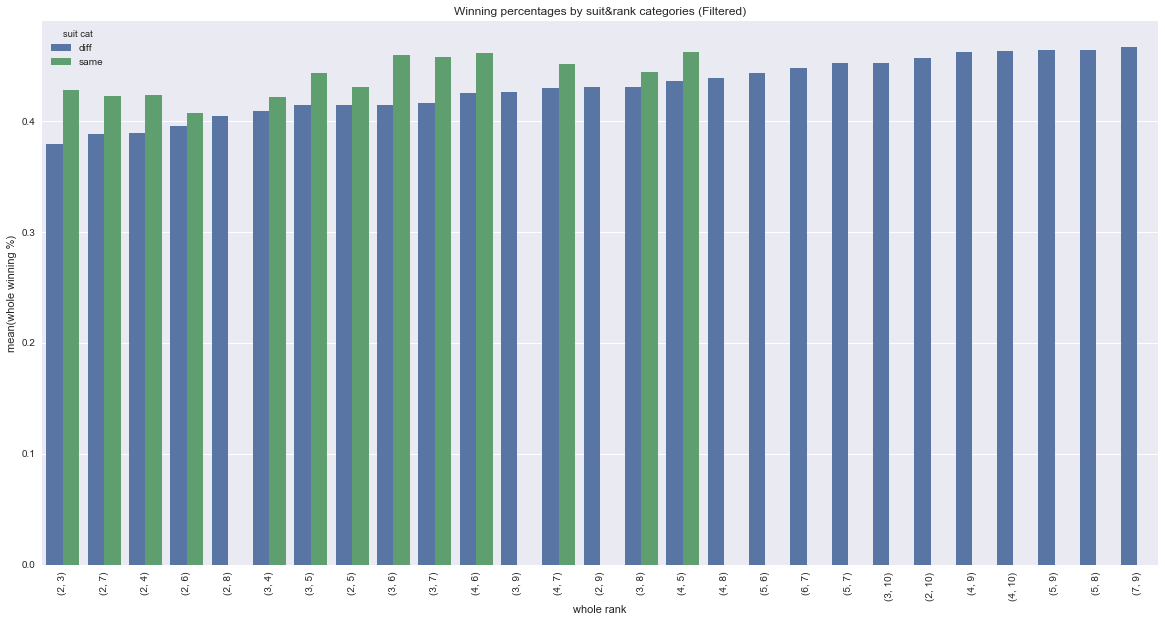

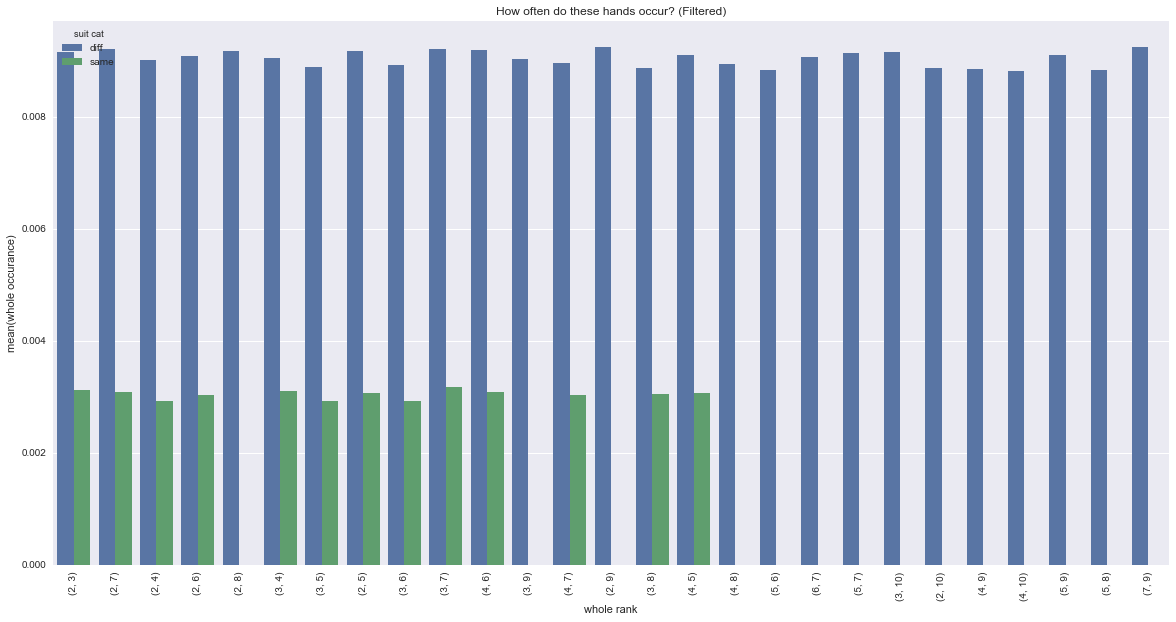

,suit cat,whole rank,whole counts,winning counts,whole occurance,whole winning %
1,diff,"(2, 3)",3666,1392,0.009165,0.379705
5,diff,"(2, 7)",3684,1432,0.009210,0.388708
2,diff,"(2, 4)",3609,1404,0.009022,0.389027
4,diff,"(2, 6)",3632,1437,0.009080,0.395650
6,diff,"(2, 8)",3671,1485,0.009177,0.404522
94,same,"(2, 6)",1210,493,0.003025,0.407438
14,diff,"(3, 4)",3619,1482,0.009047,0.409505
15,diff,"(3, 5)",3556,1475,0.008890,0.414792
3,diff,"(2, 5)",3669,1522,0.009173,0.414827
16,diff,"(3, 6)",3572,1482,0.008930,0.414894


In [31]:
temp = all_possible_whole.groupby(['suit cat', 'whole rank'])[['whole rank', 'suit cat', 'whole counts', 'winning counts']].sum().reset_index()
temp['whole occurance'] = temp['whole counts'] / hands / participants
temp['whole winning %'] = temp['winning counts'] / temp['whole counts']

temp.sort_values(by = 'whole winning %', ascending = True, inplace = True)

plt.rcParams['figure.figsize'] = [20, 10]
sns.barplot(data = temp.head(40), x = 'whole rank', y = 'whole winning %', hue = 'suit cat')
plt.xticks(rotation = 90)
plt.title('Winning percentages by suit&rank categories (Filtered)')
plt.show()

plt.rcParams['figure.figsize'] = [20, 10]
sns.barplot(data = temp.head(40), x = 'whole rank', y = 'whole occurance', hue = 'suit cat')
plt.xticks(rotation = 90)
plt.title('How often do these hands occur? (Filtered)')
plt.show()

temp.head(20)

Some of the worst hands, mind that all these are diff suits:
1. < 8%: (2, 7), (2, 8), (2, 3), (3, 8), (2, 9). All these are 5+ gapers with 2 or 3
2. 8-8.5%: (3, 9), (4, 9), (3, 7), (2, 10), (2, J), (2, 6). It's surprising that there's J involved
3. 8.5%+ :(3, J), (4, 8), (3, 10), (2, 4), (2, 5), (3, K), (3, Q), (4, 10). We are beginning to see Q and Ks.
4. The worst hand with an A is (3, A), with 9.65% winning percentage

In [32]:
i = 0
notfound = True
while notfound:
    if 14 in list(temp['whole rank'].iloc[i]):
        notfound = False
        print('worst hand with an ace is {}, winning % is {}'.format(temp['whole rank'].iloc[i], temp['whole winning %'].iloc[i]))
    i += 1

worst hand with an ace is (3, 14), winning % is 0.5695955369595537


In [33]:
i = 0
notfound = True
while notfound:
    if list(temp['whole rank'].iloc[i])[0] == list(temp['whole rank'].iloc[i])[1]:
        notfound = False
        print('worst hand with a pair is {}, winning % is {}'.format(temp['whole rank'].iloc[i], temp['whole winning %'].iloc[i]))
    i += 1

worst hand with a pair is (2, 2), winning % is 0.5541436464088397


Also what ends up winning?

In [36]:
winning_df['cls'] = winning_df['eval'].apply(lambda x: x[1])

temp = winning_df.groupby('cls')[['winner', 'whole']].agg({'winner': 'sum', 'whole': 'count'})
temp['whole occurance'] = temp['whole'] / winning_df.shape[0]
temp['whole winning %'] = temp['winner'] / temp['whole']
temp.sort_values(by = 'whole winning %', ascending = False, inplace = True)
temp.reset_index(inplace = True)
temp.head(20)

base_color = sns.color_palette()[0]
plt.rcParams['figure.figsize'] = [20, 10]
sns.barplot(data = temp, x = 'cls', y = 'whole winning %', color = base_color)
plt.xticks(rotation = 90)
plt.title('Winning percentages by class')

cat_counts = temp[['whole winning %', 'cls']]
locs, labels = plt.xticks() # get the current tick locations and labels

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):

    # get the text property for the label to get the correct count
    num = cat_counts[cat_counts['cls'] == label.get_text()]['whole winning %'].values[0]
    pct_string = '{:0.0f}%'.format(100 * num)

    # print the annotation just below the top of the bar
    plt.text(loc, count, pct_string, ha = 'center', color = 'k')

plt.show()


plt.rcParams['figure.figsize'] = [20, 10]
sns.barplot(data = temp, x = 'cls', y = 'whole occurance', color = base_color)
plt.xticks(rotation = 90)
plt.title('How often do these hands occur?')

cat_counts = temp[['whole occurance', 'cls']]
locs, labels = plt.xticks() # get the current tick locations and labels

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):

    # get the text property for the label to get the correct count
    num = cat_counts[cat_counts['cls'] == label.get_text()]['whole occurance'].values[0]
    pct_string = '{:0.2f}%'.format(100 * num)

    # print the annotation just below the top of the bar
    plt.text(loc, count - 1, pct_string, ha = 'center', color = 'k')
    
plt.show()

AttributeError: 'NoneType' object has no attribute 'seq'

TypeError: Could not operate 1 with block values unsupported operand type(s) for -: 'str' and 'int'

In [37]:
winning_df['cls'] = winning_df['eval'].apply(lambda x: x[1])

In [38]:
interested_in = 'High'
winning_df[winning_df['cls'] == interested_in][['cls','rank', 'suit cat']].groupby(['rank', 'suit cat'])[['rank', 'suit cat']].count().sort_values(by = 'rank', ascending = False).head()

,,rank,suit cat
rank,suit cat,,
"(4, 13)",diff,747,747
"(8, 13)",diff,739,739
"(9, 14)",diff,739,739
"(2, 8)",diff,734,734
"(2, 13)",diff,728,728


Answer the following questions:
    
1. what hands have very slim chance of winning? by rank and suits?
    - suits can be classified as matching or not
        - diff suits generally have low winning percentages
        - same suits occur less frequently
        - note that the pairs have different suits
    - ranks can be classified as connecting, 1 gap, 2 gaps, etc
        - those that have a 2, and not connection (5+ gaps) have the lowest chances of winning
        - surprisingly, those with high card (A, K, Q, J) + 2, 3, 4 are pretty bad as well (also 5+ gaps)
    - ranks can also be looked at by pairs, have at least an Ace, King, etc
        - Pairs are great, the worst pair is (3, 3), with 14.8% chance of winning. Well above the average
        - those that are high and have low gaps do well. They key is suited.
        
2. what is the cutoff standard for winning percentages?
    - we can sort and plot. see if there's an elbow in the plot, for the categories that we've came up with
        - there's sort of an elbow at Js. However, it's impossible to only play As, Ks, Qs and Js. 
        - the key again is to see what's tolerable compared to average. again, suited are much better.
    - we can also answer some myths:
        - are 2, 7s the worst hands? yes
        - small pairs, do they always suck? actually they are not that bad. much better than (2, A), for instance.
3. What ends up being the eventual winners?
    - what are the eventual winners and their whole? (top 5)
        - Royal Flush: (10, J) same, (10, K) same, (Q, K) same, (10, Q) same, (10, A) same
        - Straight Flush: (7, 8) same,(4, 5) same,(8, 9) same, (6, 8) same,(5, 8) diff
        - 4 of a Kind: 2s, Qs, 7s, 5s, Ks
        - Full House: As, 10s, Qs, 8s, 4s
        - Flush (note, straight has a better winning % than flush): (8, Q) same, (5, K) same, (10, K) same, (2, J) same, (J, Q) same
        - Straight: (10, J) diff, (6, 7) diff, (5, 6) diff, (9, 10) diff, (8, 9) diff
        - 3 of a Kind: As, 9s, 10s, 8s, Js
        - 2 Pairs: (2, 9) diff, (4, 10) diff, (5, J) diff, (5, 10) diff, (4, Q) diff
        - 1 Pair: (5, 10) diff, (7, 14) diff, (7, 13) diff, (8, 14) diff, (6, 11) diff
        - High Card: (2, 13) diff, (2, 9) diff, (3, 10) diff, (2, 7) diff, (7, Q) diff
        
    - how often do these winners appear?
        - Royal Flush: 0.00%
        - Straight Flush: 0.03%
        - 4 of a Kind: 0.17%
        - Full House: 2.62%
        - Flush (note, straight has a better winning % than flush): 3.02%
        - Straight: 4.63%
        - 3 of a Kind: 4.82%
        - 2 Pairs: 23.46%
        - 1 Pair: 43.79%
        - High Card: 17.46%
    - what type of hands and what are their chances of becoming eventual winners
        - reference to previous charts

In [39]:
winning_df['whole suit'].count()

KeyError: 'whole suit'

I need a function that tells me the possibilities with the whole and the community, namely the outs I have for improving my current position.

When it's whole cards, we'll look at the winning percentages by previous experiences. After the flop, we'll look at the best possible hands that would improve current position:
0. identify itself by using the 5 cards we already have.
1. add two blanks, iterate through all the possiblities:
    - look at those with the same score and above
    - list out all the possible cards that would improve position.
After the turn:
0. identify itself by using the 6 cards we already have.
1. add 1 blanks, iterate through all the possibilities:
    - look at those with the same score and above
    - list out all the possible cards that would improve position.
After the river:
0. identify itself by using the 7 cards we already have.

I also need a function that compares hands on the game board if all cards are visible. This will come from one player's POV, and evaluate hands against his opponent(s).